## Question 1

In [79]:
# a. import
import ipywidgets as widgets
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from HouseholdSpecializationModel import *
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(0.25,0.5): x = 0.545


/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/1175769368.py:92: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/1175769368.py:92: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/1175769368.py:96: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


(0.25,1): x = 0.308
(0.25,1.5): x = 0.214
(0.5,0.5): x = 1.000
(0.5,1): x = 1.000
(0.5,1.5): x = 1.000
(0.75,0.5): x = 1.833
(0.75,1): x = 3.250
(0.75,1.5): x = 4.667


Text(0.5, 0.5, 'Sigma')

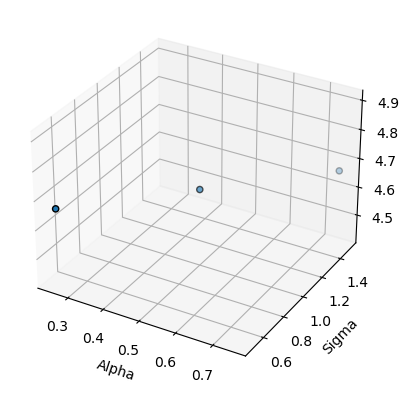

In [93]:
# %% [markdown]
# # Inaugural Project

# %% [markdown]
# > *Note the following:* 
# > 1. This is an example of how to structure your *inaugural project*.
# > 1. Remember the general advice on structuring and commenting your code
# > 1. The inauguralproject.py file includes a function which can be used multiple times in this notebook.

# %% [markdown]
# Imports and set magics:

# %%
import numpy as np

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
# import inauguralproject as model


# %% [markdown]
# # Question 1

# %% [markdown]
# *Explain how you solve the model*

# %%

from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt

class HouseholdSpecializationModelClass:

    def __init__(self):
        """ setup model """

        # a. create namespaces
        par = self.par = SimpleNamespace()
        sol = self.sol = SimpleNamespace()

        # b. preferences
        par.rho = 2.0 #tjek
        par.nu = 0.001 #tjek
        par.epsilon = 1.0 #tjek
        par.omega = 0.5 #tjek

        # c. household production
        par.alpha = 0.5 #tjek
        par.sigma = 1.0 #tjek

        # d. wages
        par.wM = 1.0 #tjek
        par.wF = 1.0 #tjek
        par.wF_vec = np.linspace(0.8,1.2,5)

        # e. targets
        par.beta0_target = 0.4
        par.beta1_target = -0.1

        # f. solution
        sol.LM_vec = np.zeros(par.wF_vec.size)
        sol.HM_vec = np.zeros(par.wF_vec.size)
        sol.LF_vec = np.zeros(par.wF_vec.size)
        sol.HF_vec = np.zeros(par.wF_vec.size)

        sol.beta0 = np.nan
        sol.beta1 = np.nan

    def calc_utility(self,LM,HM,LF,HF):
        """ calculate utility """

        par = self.par
        sol = self.sol

        # a. consumption of market goods
        C = par.wM*LM + par.wF*LF

        # b. home production
        if par.sigma == 0:
            H = optimize.minimize(HF,HM)
        elif par.sigma == 1:
            H = HM**(1-par.alpha)*HF**par.alpha
        else:
            H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
       
        # c. total consumption utility
        Q = (C**par.omega)*(H**(1-par.omega))
        utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)

        # d. disutlity of work
        epsilon_ = 1+1/par.epsilon
        TM = LM+HM
        TF = LF+HF
        disutility = par.nu*(TM**epsilon_/epsilon_+TF**epsilon_/epsilon_)
        
        return utility - disutility

    def solve_discrete(self,do_print=False):
        """ solve model discretely """
        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace()
        
        # a. all possible choices
        x = np.linspace(0,24,49)
        LM,HM,LF,HF = np.meshgrid(x,x,x,x) # all combinations
    
        LM = LM.ravel() # vector
        HM = HM.ravel()
        LF = LF.ravel()
        HF = HF.ravel()

        # b. calculate utility
        u = self.calc_utility(LM,HM,LF,HF)
    
        # c. set to minus infinity if constraint is broken
        I = (LM+HM > 24) | (LF+HF > 24) # | is "or"
        u[I] = -np.inf
    
        # d. find maximizing argument
        j = np.argmax(u)
        
        opt.LM = LM[j]
        opt.HM = HM[j]
        opt.LF = LF[j]
        opt.HF = HF[j]

        # e. print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')

        return opt
    
    def solve_cont(self,do_print=False):
                        
        par = self.par
        sol = self.sol
        opt = SimpleNamespace

        def objective(x):
            return self.calc_utility(x[0],x[1],x[2],x[3])
        
        obj = lambda x: - objective(x)
        constraints = ({'type': 'ineq', 'fun': lambda x: (x[0]+x[1] - 24 ) and (x[0]+x[2] - 24)})
        guess = [4]*4
        bounds = [(0, 24)]*4

        result = optimize.minimize(obj,
                            guess,
                            method='SLSQP',
                            bounds=bounds,
                            constraints=constraints)
    
        opt_result = {
            'HF': result.x[0],
            'HM': result.x[1],
            'LF': result.x[2],
            'LM': result.x[3],
        }

        return opt_result
        
        #print
        if do_print:
            for k,v in opt.__dict__.items():
                print(f'{k} = {v:6.4f}')
        
        return opt

# %%


# Define the values of alpha and sigma to use

alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]
mo = HouseholdSpecializationModelClass()
for alpha in alpha_values:
    for sigma in sigma_values:
        mo.par.alpha = alpha
        mo.par.sigma = sigma
        res = mo.solve_discrete()

        print(f'({alpha},{sigma}): x = {res.HF/res.HM:.3f}')


fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter3D(alpha_values, sigma_values, res.HF/res.HM ,edgecolor='black')

# b. add labels
ax.set_xlabel('Alpha')
ax.set_ylabel('Sigma')

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot_surface(sigma_values, alpha_values, res.HF/res.HM,alpha = 0.5)

ax.scatter(x_gs_mesh, y_gs_mesh, g(x_gs_mesh,y_gs_mesh), marker='.', color='red', alpha=0.5, label='Grid points')
ax.scatter(x_best, y_best, g(x_best,y_best), marker='o', s=30, color='black', label='Minimum, grid search')

ax.scatter(res.x[0], res.x[1], res.fun, marker='o', s=30, color='magenta', label='Minimum, solver')

ax.legend()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$g(x,y)$');


In [81]:
# Lister med alpha og sigma værdier til loop
alpha_values = [0.25, 0.5, 0.75]
sigma_values = [0.5, 1, 1.5]

In [82]:
#Returner H forhold for loop over alpha og sigma værdier
H_div = []

for i,j in zip(alpha_values, sigma_values):
    model = HouseholdSpecializationModelClass()
    model.par.alpha = i
    model.par.sigma = j 
    opt = model.solve_discrete()
    H_div.append(opt.HF/opt.HM)
print(H_div)


/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:92: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:92: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:96: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


[0.5454545454545454, 1.0, 4.666666666666667]


Text(0.5, 0.5, 'Sigma')

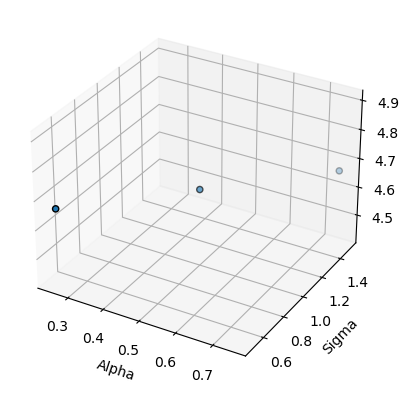

In [83]:
#plot for alpha og sigma værdier

# a. Answer
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.scatter3D(alpha_values, sigma_values, res.HF/res.HM ,edgecolor='black')

# b. add labels
ax.set_xlabel('Alpha')
ax.set_ylabel('Sigma')


## Question 2:


In [84]:
#Returner H forhold for loop over alpha og sigma værdier
H_div_log = []

for i,j in zip(alpha_values, sigma_values):
    model = HouseholdSpecializationModelClass()
    model.par.alpha = i
    model.par.sigma = j 
    opt = model.solve_discrete()
    H_div_log.append(math.log(opt.HF/opt.HM))
print(H_div_log)


/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:92: RuntimeWarning: divide by zero encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:92: RuntimeWarning: invalid value encountered in reciprocal
  H = ((1-par.alpha)*HM**((par.sigma-1)/par.sigma)+par.alpha*HF**((par.sigma-1)/par.sigma))**(par.sigma/(par.sigma-1))
/var/folders/q_/vqvmlj2j519bgbc5rhd532sr0000gn/T/ipykernel_1427/117419528.py:96: RuntimeWarning: invalid value encountered in reciprocal
  utility = np.fmax(Q,1e-8)**(1-par.rho)/(1-par.rho)


[-0.6061358035703156, 0.0, 1.540445040947149]


In [85]:
# Forhold mellem WF og WM
wF_values = [0.8, 0.9, 1.0, 1.1, 1.2]
wM = 1.0
Log_ratio = []
import math
for wF in wF_values:
    model = HouseholdSpecializationModelClass()
    model.par.wF = wF
    model.par.wM = wM
    opt = model.solve_cont()
    Log_ratio.append(math.log(opt['HF']/opt['HM']))
print(Log_ratio)
print(opt['HF'], opt['HM'], opt['LF'],opt['LM'])

[1.610250044936436, 1.623837484433484, 1.6371028251543966, 1.6499884590993392, 1.6624633932498083]
11.966175515186194 2.2696385039142766 12.033824484813806 2.268959165437749


## Question 3: